# MNIST Number Lightweight Classifier using Lasso Regression
### Import statements and notebook settings

In [10]:
import copy
import time
import math
from typing import List

from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd

show_mnist_plots = True

### Plotting helper functions

In [11]:
def plot_heat_map_vector(coef_arr: List[np.array], lambda_labels: List[float], fig_size_x: int = 12, fig_size_y: int = 12) -> None:
    """For each element of coef_arr, we plot a heat map. This is used for visualizing which pixels are
    being used in the filter.

    Args:
        coef_arr (List[np.array]): List of 2D np arrays containing coefficients to plot
        lambda_labels (List[float]): List of lambda values to label plots. Must have length equal to coef_arr
        fig_size_x (int): x-dim of figure size. Defaults to 12.
        fig_size_y (int): y-dim of figure size. Defaults to 12.
    """
    plt.rcParams['figure.figsize'] = [fig_size_x, fig_size_y]

    fig,axs = plt.subplots(len(lambda_labels),1)
    if len(lambda_labels) == 1:
        axs = [axs]
    for j, coef in enumerate(coef_arr):
        x_pcolor = axs[j].pcolor(coef,cmap='plasma')
        fig.colorbar(x_pcolor, ax=axs[j])
        axs[j].set_ylabel(f"lambda={lambda_labels[j]}") 
    return

def plot_heat_map_image(model_coef: np.array, lambda_val: float, num_labels: int = 10, comp_factor: int = 0, pixel_width: int = 28, fig_size: int = 7) -> None:
    """Plot model coefficients for each label as an image to highlight important features. It is used to 
    visualize which pixels are highly weighted by each label based on the training data.

    Args:
        model_coef (np.array): 3D array where each element has shape pixel_width*pixel_width
        lambda_val (float): Lambda weight used for model generation. Used in title
        num_labels (int, optional): Number of labels in model_coef. Defaults to 10.
        comp_factor (int, optional): Compression factor label for title. Defaults to 0, in which case this is ignored.
        pixel_width (int, optional): Number of pixels/elements for each label coef square matrix. Defaults to 28.
        fig_size (int, optional): size of figure. Defaults to 7.
    """
    plt.rcParams['figure.figsize'] = [fig_size*1.5, fig_size]
    model_image = np.reshape(model_coef, (num_labels, pixel_width, pixel_width))
    subplot_row = math.floor(np.sqrt(num_labels))
    subplot_col = math.ceil(np.sqrt(num_labels))
    _, axs = plt.subplots(subplot_row, subplot_col)
    for i, image in enumerate(model_image):
        row = i//subplot_col
        col = i%subplot_col
        axs[row, col].set_title(f"Label = {i}")
        axs[row, col].imshow(image, cmap=plt.get_cmap('plasma'))
    for i in range(subplot_col*subplot_row):
        row = i//subplot_col
        col = i%subplot_col
        axs[row, col].axis('off')
    title = f"Lambda = {lambda_val}"
    if comp_factor:
        title = title + f"; Compression = {comp_factor:.2f}%"
    plt.suptitle(title)
    plt.show()
    return

def plot_confusion(model_coef: np.array, test_data: np.array, test_label: np.array, lambda_val: float, comp_factor: int = 0, fig_size: int = 12) -> None:
    """Plots the confusion matrix for a given model coefficients and test data

    Args:
        model_coef (np.array): 2D array of model coefficients
        test_data (np.array): data used for testing model
        test_label (np.array): labels of true outputs
        lambda_val (float): lambda weight used for model generation. Used for title
        comp_factor (int, optional): Compression factor label for title.. Defaults to 0, in which case this is ignored.
        fig_size (int, optional): size of figure. Defaults to 12.
    """
    plt.rcParams['figure.figsize'] = [fig_size, fig_size*0.8]
    pred = test_data@model_coef.T
    
    conf_pred = np.argmax(pred, axis=1)
    conf_mat = confusion_matrix(test_label, conf_pred, normalize='pred')
    disp = ConfusionMatrixDisplay(conf_mat)
    disp.plot()
    title = f"Lambda = {lambda_val}"
    if comp_factor:
        title = title + f"; Compression = {comp_factor:.2f}%"
    plt.title(title)
    plt.show()
    return


### Import MNIST data and vectorize the data
Each of the images is vectorized (28*28 pixel image is converted to 784 element vector) and combined into a single array (see data labeled with `_A`). One-hot encoding is used to create the solution matrix from the labels (see data labeled with `_B`).

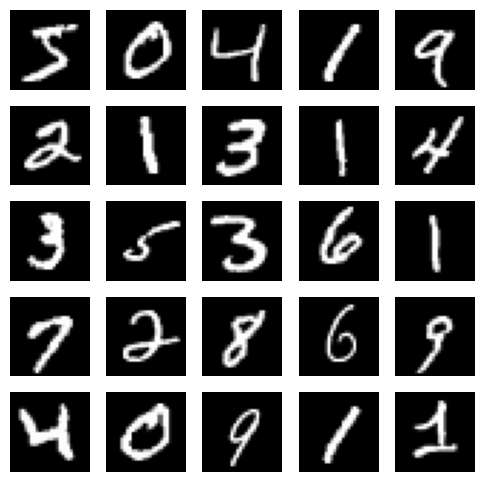

In [3]:
fig_size = 6
plt.rcParams['figure.figsize'] = [fig_size, fig_size]

(train_data, train_label), (test_data, test_label) = mnist.load_data()

if show_mnist_plots:
    mnist_plots = (5)**2     # set to be squared number
    root_mnist = int(np.sqrt(mnist_plots))
    fig, axs = plt.subplots(root_mnist, root_mnist)
    for i in range(mnist_plots):
        row = i//root_mnist
        col = i%root_mnist
        axs[row, col].imshow(train_data[i], cmap=plt.get_cmap('gray'))
        axs[row, col].axis('off')
    plt.show()

num_labels = 10     # set equal to number of labels (digits)

def one_hot(labels, num_labels):
    """return array of one-hot encoding to match number of labels"""
    return np.eye(num_labels)[np.array(labels).reshape(-1)]

def vectorize_data(data, label, num_labels):
    """flatten each image in data into 1D array and create one-hot encoding result matrix"""
    data_vector = data.reshape(data.shape[0], -1)
    label_vector = one_hot(label, num_labels)
    return data_vector, label_vector

train_A, train_B = vectorize_data(train_data, train_label, num_labels)
test_A, test_B = vectorize_data(test_data, test_label, num_labels)

### Solve $AX=B$ using Lasso regularization
For this example, $AX=B$ is an overdetermined system, where $A$ is the matrix of vectorized images and $B$ is the solution matrix created using one-hot encoding from the labels. Lasso regularization is used to find an approximate solution to the system of equations and is shown in the following equation.

\begin{equation}
\hat{X} = min||AX - B||_2 + \lambda||X||_1 
\end{equation}

where $||\cdot||_1$ is the L1 norm, $||\cdot||_2$ is the L2 norm, $\lambda$ is the regularization factor, and $\hat{X}$ is the approximate solution for $X$.

Larger values of $\lambda$ will increase the cost function such that more values of $\hat{X}$ will be 0. This incentivizes a sparse solution useful for building lightweight models.

The results show that as $\lambda$ is increased, the number of non-zero elements decreases. The heatmaps visualize the $\hat{X}$ data for each $\lambda$, where the x-axis displays the weights for each pixel and the y-axis displays the weights for each label (or digit).

iter 0: lambda = 0.0001	solve time: 226.0 sec	non-zero elem: 6730	
iter 1: lambda = 0.01	solve time: 79.5 sec	non-zero elem: 4094	
iter 2: lambda = 0.1	solve time: 43.3 sec	non-zero elem: 2246	
iter 3: lambda = 1	solve time: 28.7 sec	non-zero elem: 829	


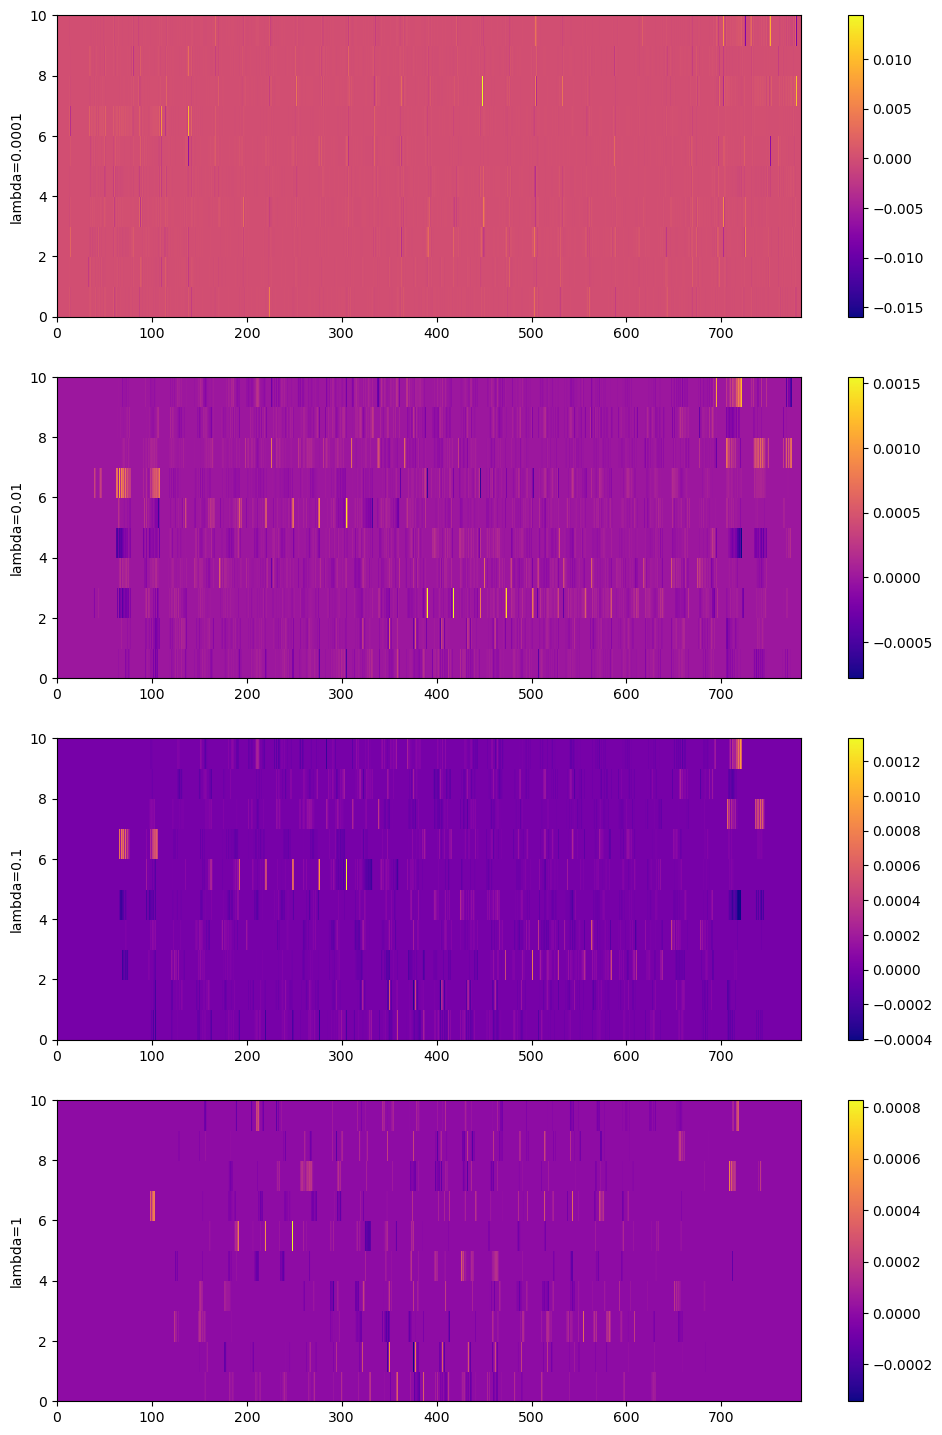

In [27]:
# lambda is regularization factor in Lasso algo
lambda_array = [1e-4, 1e-2, 1e-1, 1]

def generate_clf_models(A: np.array, b: np.array, lambda_array: List[float], max_iter:int = 1000) -> List:
    """Generate classifier models using linear regression. Using training matrix A and training outputs b, a separate 
    model is generated for each element in lambda_array.

    Args:
        A (np.array): array of training data to generate model
        b (np.array): array of training outputs to generate model
        lambda_array (List[float]): vector of int containing lambda weights. If elem is 0, then standard linear regression
        is used. If elem is non-0, then Lasso regression algorithm is used.
        max_iter (int): maximum number of iterations

    Returns:
        List: list of classifier models equal in length to lambda_array
    """
    clf_list = []
    for i, lam in enumerate(lambda_array):
        start = time.time()
        if lam == 0:
            clf = linear_model.LinearRegression(fit_intercept=False)
        else:
            clf = linear_model.Lasso(alpha=lam, 
                                     fit_intercept=False, 
                                     selection='random',
                                     max_iter=max_iter,
                                     )
        clf.fit(A, b)
        elapsed = time.time() - start
        print(f"iter {i}: lambda = {lam}\t"
              f"solve time: {elapsed:3.1f} sec\t"
              f"non-zero elem: {np.count_nonzero(clf.coef_)}\t"
            #   f"iterations: {np.average(clf.n_iter_)}"
              )
        clf_list.append(clf)
    return clf_list

clf_array = generate_clf_models(train_A, train_B, lambda_array)

plot_heat_map_vector([model.coef_ for model in clf_array], lambda_array, fig_size_y=18)

plt.show()

### Feature Highlights by Lambda Weight
The coefficients for each label (digit) can be remapped into a 28*28 array to highlight how each pixel contributes to, detracts from, or has no effect on the image's score for a particular label. It is interesting to note that as the solution is forced towards sparsity (i.ei higher lambda values), it is much easier to see the features of each label from the training set.

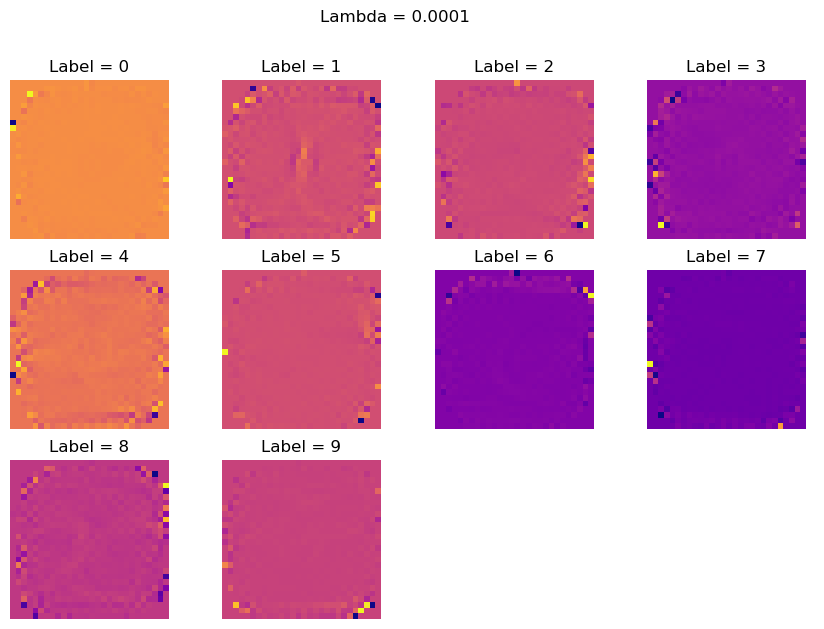

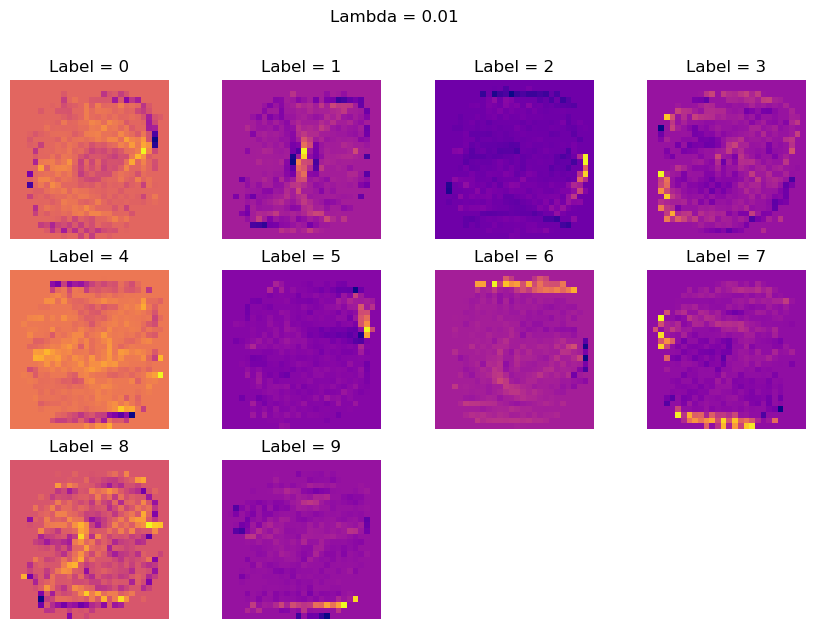

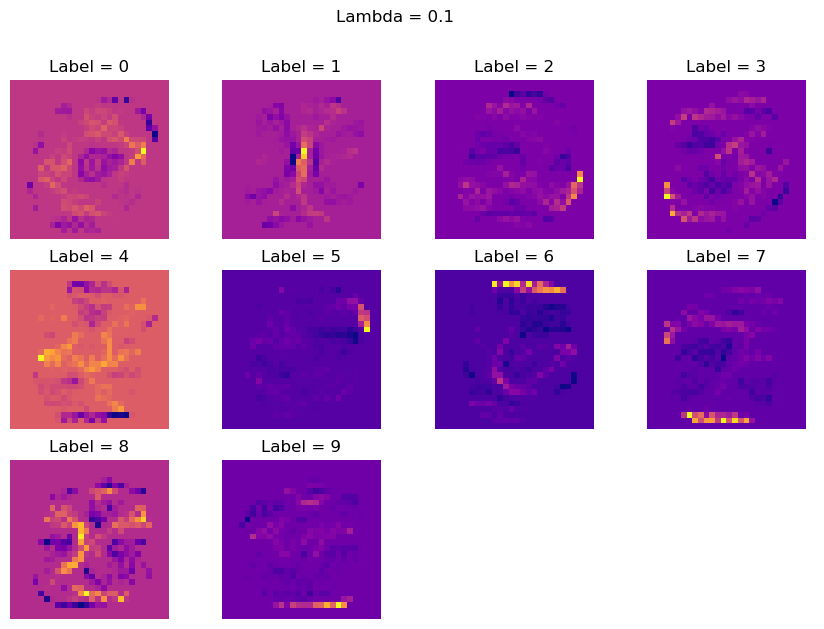

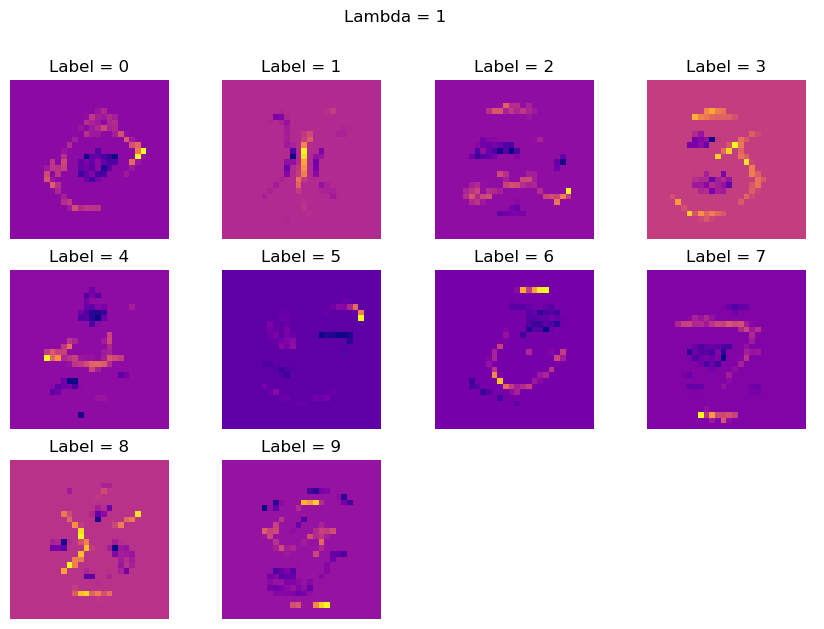

In [28]:
# plot heat map coef
for i, clf in enumerate(clf_array):
    plot_heat_map_image(clf.coef_, lambda_array[i])

### Classification Report
As shown below, the f1-score does not change (much) with the increasing value of $\lambda$

In [29]:
def disp_model_char(model: np.array):
    """Display model characteristics."""
    print(f"Classification report:\t"
          f"lambda: {lambda_val}\t"
          f"iterations: {np.average(model.n_iter_)}\t"
          f"elements: {np.count_nonzero(model.coef_)}")
    return

def print_classification_report(model_coef: np.array, test_data: np.array, test_label: np.array, label_list: List[int], print_all: bool = False):
    """Print the classification report for a given model and test data set. If print_all is True then the entire report is printed; else a truncated version is used."""
    pred = test_data@model_coef.T
    pred_val = np.argmax(pred, axis=1)
    if print_all:
        print(classification_report(test_label, pred_val, labels=label_list))
    else:
        report = classification_report(test_label, pred_val, labels=label_list, output_dict=True)
        report_df = pd.DataFrame(data=report).round(2)
        col_mask = ["accuracy","macro avg","weighted avg"]
        print(f"{report_df.drop(labels='support').get(col_mask).transpose()}\n")
    return

labels = [i for i in range(10)]
for i, clf in enumerate(clf_array):
    disp_model_char(clf)
    print_classification_report(clf.coef_, test_A, test_label, labels, )

Classification report:	lambda: 0.1	iterations: 728.4	elements: 6730
              precision  recall  f1-score
accuracy           0.85    0.85      0.85
macro avg          0.85    0.85      0.85
weighted avg       0.85    0.85      0.85

Classification report:	lambda: 0.1	iterations: 345.5	elements: 4094
              precision  recall  f1-score
accuracy           0.85    0.85      0.85
macro avg          0.86    0.85      0.85
weighted avg       0.86    0.85      0.85

Classification report:	lambda: 0.1	iterations: 231.4	elements: 2246
              precision  recall  f1-score
accuracy           0.85    0.85      0.85
macro avg          0.85    0.85      0.85
weighted avg       0.85    0.85      0.85

Classification report:	lambda: 0.1	iterations: 181.0	elements: 829
              precision  recall  f1-score
accuracy           0.82    0.82      0.82
macro avg          0.83    0.82      0.82
weighted avg       0.83    0.82      0.82



### Confusion Matrix
The confusion matrix is plotted showing the TPR along the diagonal. The FPR is shown on all other elements. The data has been normalized in order to show the precision of the model.

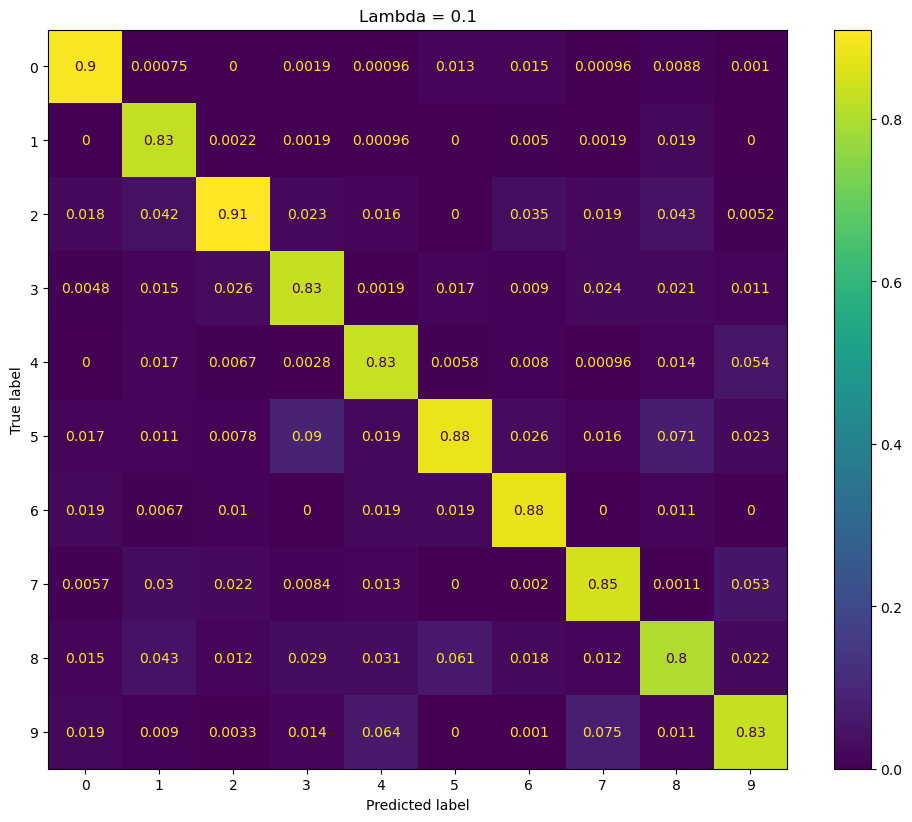

In [30]:
model_ind = 2
lambda_val = lambda_array[model_ind]
model = clf_array[model_ind]
model_coef = model.coef_
plot_confusion(model_coef, test_A, test_label, lambda_val)


### Further Model Compression
The model can be further compressed by zero-ing the smallest coefficients. The number of non-zero coefficients should be kept above ~10% of the total coefficients in $\hat{X}$ to keep the f1-score high. Model degradation is shown when the model is compressed below this limit.

# of non-zero elements in base model: 2246


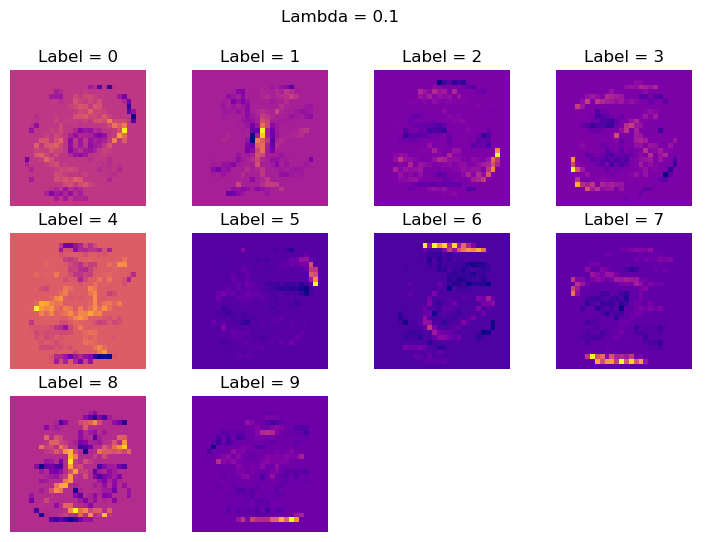

# of non-zero elements in compressed model: 1719 (Compression: 0.23%)
              precision  recall  f1-score
accuracy           0.84    0.84      0.84
macro avg          0.85    0.84      0.84
weighted avg       0.85    0.84      0.84



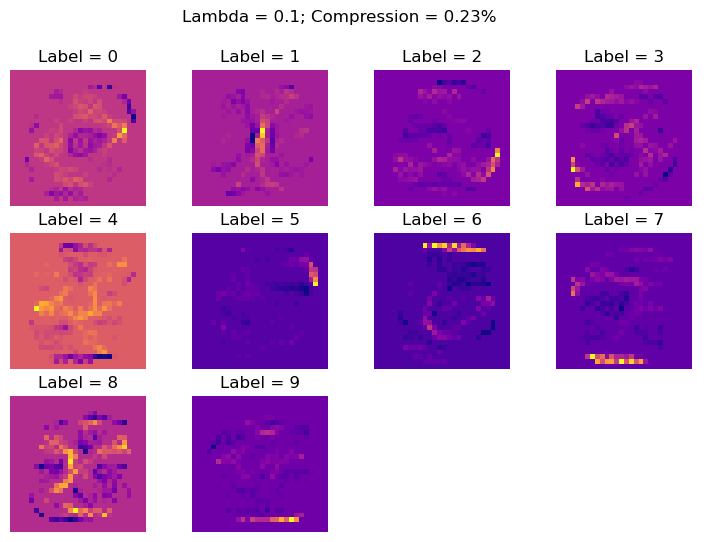

# of non-zero elements in compressed model: 720 (Compression: 0.68%)
              precision  recall  f1-score
accuracy           0.72    0.72      0.72
macro avg          0.76    0.71      0.70
weighted avg       0.76    0.72      0.70



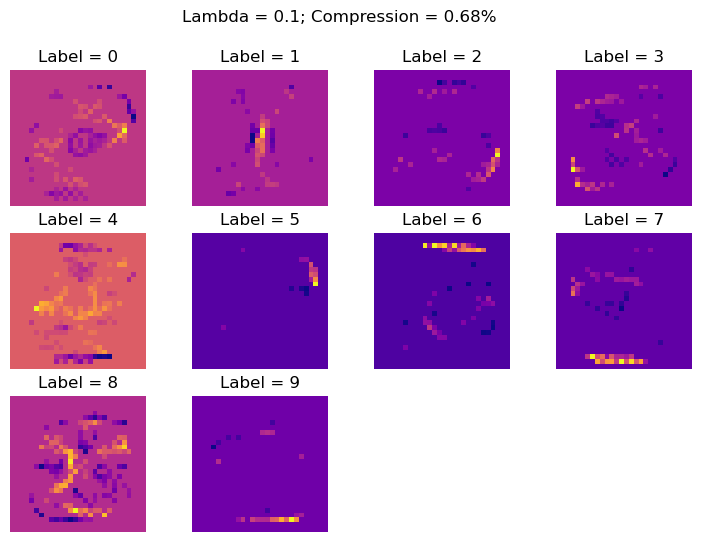

In [31]:
# Compress model for selected lambda
def compress_model(coef,threshold):
    """compress model by zeroing all coefficients below threshold, 
    where the threshold is defined as the percentage of the max coef
    """
    
    threshold_val = coef.max()*threshold
    comp_coef = copy.deepcopy(coef)
    comp_coef[np.abs(comp_coef) < threshold_val] = 0
    return comp_coef

def compress_model_by_row(coef,threshold):
    """compress model by zeroing all coefficients below threshold by row, 
    where the threshold is defined as the percentage of the max coef per row
    """
    threshold_val = coef.max(axis=1)*threshold
    comp_coef = copy.deepcopy(coef)
    comp_coef[np.abs(comp_coef) < threshold_val[:, np.newaxis]] = 0
    return comp_coef

def disp_comp_model_stats(base_model, comp_model, lambda_val, plot_hmap=False, plot_conf=False):
    """Helper function to display common data for compressed models"""
    base_elem = np.count_nonzero(base_model)
    comp_model_elem = np.count_nonzero(comp_model)
    comp_factor = 1 - comp_model_elem/base_elem
    print(f"# of non-zero elements in compressed model: {comp_model_elem} (Compression: {comp_factor:.2f}%)")
    if plot_hmap: plot_heat_map_vector([comp_model], [lambda_val], fig_size_y=4)
    if plot_conf: plot_confusion(comp_model, test_A, test_label, lambda_val, comp_factor=comp_factor)
    return comp_factor

fsize = 6
base_elem = np.count_nonzero(model_coef)
print(f"# of non-zero elements in base model: {base_elem}")
plot_heat_map_image(model_coef, lambda_val, fig_size=fsize)

threshold = 0.03
# comp_model_abs = compress_model(model_coef, threshold)
# disp_comp_model_stats(model_coef, comp_model_abs, lambda_val)
comp_model_by_row = compress_model_by_row(model_coef, threshold)
comp_factor = disp_comp_model_stats(model_coef, comp_model_by_row, lambda_val)
print_classification_report(comp_model_by_row, test_A, test_label, labels)
plot_heat_map_image(comp_model_by_row, lambda_val, comp_factor=comp_factor, fig_size=fsize)

comp_model_by_row_too_scarce = compress_model_by_row(model_coef, 4*threshold)
comp_factor = disp_comp_model_stats(model_coef, comp_model_by_row_too_scarce, lambda_val)
print_classification_report(comp_model_by_row_too_scarce, test_A, test_label, labels)
plot_heat_map_image(comp_model_by_row_too_scarce, lambda_val, comp_factor=comp_factor, fig_size=fsize)




### References
*Data Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control* by Steve L. Brunton and J. Nathan Kutz